In [11]:
traindata_rate=[0.7,0.8,0.9]

# Fitness Function

In [20]:
import numpy as np
import pandas as pd
from sklearn import cross_validation, ensemble, preprocessing, metrics
import pandas as pd
import numpy as np
from sklearn import preprocessing, linear_model
from sklearn.feature_selection import f_regression

def create_chromsom_value_X(filename):
    chromosom_value_X=[]
    ETF_train = pd.read_csv(filename)
    col_list=list(ETF_train.columns)

    for index in range(0,len(col_list)-1):
        chromosom_value_X.append([0,1])
    return chromosom_value_X

def create_chromsom_value_all(filename):
    chromosom_value=create_chromsom_value_X(filename)
    chromosom_value.append(traindata_rate)
    return chromosom_value

def create_x_tmp(ETF_train,col_list,chromosome):
    x_tmp=[]
    for index in range(0,len(col_list)-1):
        if chromosome[index] ==1:
            x_tmp.append(ETF_train[col_list[index]])
    return x_tmp


def Logistic_Regressionn_model(filename,chromsome):
    # 載入資料
    ETF_train = pd.read_csv(filename)
    col_list=list(ETF_train.columns)

    traindata_rate=chromsome[len(col_list)-1]

    # 建立訓練與測試資料
    x_tmp=create_x_tmp(ETF_train,col_list,chromsome)
    ETF_X = pd.DataFrame(x_tmp).T
    ETF_Y = ETF_train["Y"]

    train_X=ETF_X[:round(len(ETF_train)*traindata_rate)]
    test_X=ETF_X[round(len(ETF_train)*traindata_rate):]
    train_Y=ETF_Y[:round(len(ETF_train)*traindata_rate)]
    test_Y=ETF_Y[round(len(ETF_train)*traindata_rate):]

    # 建立 random forest 模型
    logistic_regr = linear_model.LogisticRegression()
    logistic_regr.fit(train_X,train_Y)

    survived_predictions = logistic_regr.predict(test_X)
    accuracy = logistic_regr.score(test_X,test_Y)
    return accuracy

# GA Function

In [13]:
filename='featured/0053_01.csv'
chromosom_value=create_chromsom_value_all(filename)

import random
def createrandomList(create_number,category):
    list_random = [ random.randint(0,category) for i in range(create_number)]
    return(list_random)

#init create population chromosome(100)--function input：filename & population, output：population_list 
def create_population(population):
    population_list=[]
    for popu in range(population):
        chromosome_create=[]
        for index in chromosom_value:
            chromosome_create.append(index[createrandomList(1,len(index)-1)[0]]) #從chromosom_value隨機產生一個值塞到
        population_list.append(chromosome_create)
    return population_list

def cross(cross_rate,chromosome_1,chromosome_2):
    random_rate=random.random()
    if(random_rate>cross_rate):
        point_1=random.randint(0,len(chromosome_1)-1)
        point_2=random.randint(0,len(chromosome_1)-1)

        while(point_1>=point_2):
            point_1=random.randint(0,len(chromosome_1)-1)
            point_2=random.randint(0,len(chromosome_1)-1)

#         print("cross_point1: "+str(point_1))
#         print("cross_point2: "+str(point_2))
#         print("cross_len_chromosome_1= "+str(len(chromosome_1)))
#         print("cross_len_chromosome_2= "+str(len(chromosome_2)))

        tmp=0
        for index in range(point_1,point_2+1):
            tmp=chromosome_1[index]
            chromosome_1[index]=chromosome_2[index]
            chromosome_2[index]=tmp
    return chromosome_1

def mutation(mutation_rate,chromosome):
    random_rate=random.random()
    if(random_rate>mutation_rate):
#         print("mutation_start")
        point_1=random.randint(0,len(chromosome)-1)#產生二個隨機point1 & point2 為了到時候mutation
        point_2=random.randint(0,len(chromosome)-1)
        while(point_1==point_2):#如果point1 point2 一樣要重新產生
            point_1=random.randint(0,len(chromosome)-1)
            point_2=random.randint(0,len(chromosome)-1)
#         print("mu_point1= "+str(point_1))
#         print("mu_point2= "+str(point_2))

        tmp=chromosome[point_1]#改變染色體中第point1的值，如果產生的新值與舊的一樣要再重新產生
        #chromosome[point_1]值等於chromosom_value裡面隨機產生的一個值createrandomList(1,len(chromosom_value[point_1])-1)[0]
        chromosome[point_1]=chromosom_value[point_1][createrandomList(1,len(chromosom_value[point_1])-1)[0]]#
        while(tmp==chromosome[point_1]):
            chromosome[point_1]=chromosom_value[point_1][createrandomList(1,len(chromosom_value[point_1])-1)[0]]

        tmp_2=chromosome[point_2]#改變染色體中第point2的值，如果產生的新值與舊的一樣要再重新產生
        chromosome[point_2]=chromosom_value[point_2][createrandomList(1,len(chromosom_value[point_2])-1)[0]]
        while(tmp_2==chromosome[point_2]):
            chromosome[point_2]=chromosom_value[point_2][createrandomList(1,len(chromosom_value[point_2])-1)[0]]
    return chromosome

def calculateY_rank(rank_number,population_list,filename):
    result_all_x_fitness=[]#記錄所有population與產生的y
    best_result=[]#記錄最好的population&y

    for index in population_list:
        fitness_value=Logistic_Regressionn_model(filename,index)#calculate fintness_value
        result_all_x_fitness.append([fitness_value,index])
    
    result_rank=[]#record before rank"s x & fitness_value
    for index in range(0,rank_number):
        result_rank.append(sorted(result_all_x_fitness,reverse=True)[index])#sort:big->small
    best_result=result_rank[0]
    
    x_final=[]#記錄前十五名的染色體
    for index in result_rank:
        x_final.append(index[1])
    return [x_final,best_result]

#產生新的X(上一代最好的前15個交配+突變產生新的15個+隨機產生85個新的x)--function
def create_new_x(rank_number,population,cross_rate,mutation_rate,x_final):
    new_x=[]
    #先把前15名的染色體做交配&突變->產生新15個染色體
    for index in range(0,rank_number):
        other_ch=createrandomList(1,rank_number-1)[0]
        while(index==other_ch):
            other_ch=createrandomList(1,rank_number-1)[0] #變矩陣要減1 if index= other_ch -> create other_ch again
#         print("i_th chromosome: "+str(index))
#         print("other_random_chromosome: "+str(other_ch))
        cross_result=cross(cross_rate,x_final[index],x_final[other_ch])
        new_x.append(mutation(mutation_rate,cross_result))

    #隨機產生第16~100的染色體
    for index in range(0,population-rank_number):
        new_x.append(create_population(1)[0])
    return new_x

# Main:Logistic Regression+GA

In [21]:
#GA + regression ->main
print(filename)
import datetime
#init parameter
#filename='0051_random.csv'
iteration=60
iteration_now=0
population=100
rank_number=10

cross_rate=0.3
mutation_rate=0.3

y_target=20000#fitnessvalue的目標，到達就停止迭代
y_best=-1#目前為止(所有迭代中)最好的fitnessvalue
y_now=-1#當前此迭代中最好的fitnessvalue
x_best=[]
y_best_everyiteration=[]

population_list=create_population(population)#產生初始母體染色體

Totalstarttime=datetime.datetime.now()
print("Start GA: "+str(Totalstarttime))
while(not(iteration_now>=iteration or y_best>y_target)):
    iteration_now=iteration_now+1
    print("\niteration_now= "+str(iteration_now))
    Y=calculateY_rank(rank_number,population_list,filename) #return X_final(前15名的染色體) & best_result(此代最好的fitness跟染色體)
    y_now=Y[1][0]
    print("y_now= "+str(y_now))
    if y_now>y_best:
        y_best=y_now
        x_best=Y[1][1]
        #print("x_best= "+str(x_best))
    print("y_best= "+str(y_best))
    y_best_everyiteration.append(y_best)
    population_list=create_new_x(rank_number,population,cross_rate,mutation_rate,Y[0])

print("iteration_now= "+str(iteration_now))
print("y_best= "+str(y_best))
print("x_best= "+str(x_best))

print("GA's end time is "+str(datetime.datetime.now()))
print("All time spends:  "+str(datetime.datetime.now()-Totalstarttime))


featured/0053_01.csv
Start GA: 2018-05-28 16:16:26.403135

iteration_now= 1
y_now= 0.535809018568
y_best= 0.535809018568

iteration_now= 2
y_now= 0.595238095238
y_best= 0.595238095238

iteration_now= 3
y_now= 0.587301587302
y_best= 0.595238095238

iteration_now= 4
y_now= 0.587301587302
y_best= 0.595238095238

iteration_now= 5
y_now= 0.603174603175
y_best= 0.603174603175

iteration_now= 6
y_now= 0.571428571429
y_best= 0.603174603175

iteration_now= 7
y_now= 0.571428571429
y_best= 0.603174603175

iteration_now= 8
y_now= 0.595238095238
y_best= 0.603174603175

iteration_now= 9
y_now= 0.579365079365
y_best= 0.603174603175

iteration_now= 10
y_now= 0.595238095238
y_best= 0.603174603175

iteration_now= 11
y_now= 0.571428571429
y_best= 0.603174603175

iteration_now= 12
y_now= 0.571428571429
y_best= 0.603174603175

iteration_now= 13
y_now= 0.571428571429
y_best= 0.603174603175

iteration_now= 14
y_now= 0.555555555556
y_best= 0.603174603175

iteration_now= 15
y_now= 0.579365079365
y_best= 0.6031

# GA 迭代圖

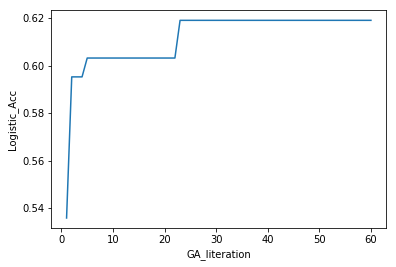

featured/0053_01.csv


In [22]:
import matplotlib.pyplot as plt
plt.plot(list(range(1,iteration+1)),y_best_everyiteration)
plt.xlabel("GA_literation")
plt.ylabel("Logistic_Acc")
plt.show()
print(filename)

In [69]:
print(list(range(1,5)))

[1, 2, 3, 4]


# 圖_TRY

In [23]:
#x_best= [1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0.8]
#filename='0051_random.csv'
chromsome=x_best

ETF_train = pd.read_csv(filename)
col_list=list(ETF_train.columns)

traindata_rate=chromsome[len(col_list)-1]

# 建立訓練與測試資料
x_tmp=create_x_tmp(ETF_train,col_list,chromsome)
ETF_X = pd.DataFrame(x_tmp).T
ETF_Y = ETF_train["Y"]

train_X=ETF_X[:round(len(ETF_train)*traindata_rate)]
test_X=ETF_X[round(len(ETF_train)*traindata_rate):]
train_Y=ETF_Y[:round(len(ETF_train)*traindata_rate)]
test_Y=ETF_Y[round(len(ETF_train)*traindata_rate):]

# 建立 random forest 模型
logistic_regr = linear_model.LogisticRegression()
logistic_regr.fit(train_X,train_Y)

survived_predictions = logistic_regr.predict(test_X)
accuracy = logistic_regr.score(test_X,test_Y)
print(accuracy)

0.507936507937


混淆矩陣:
  [[21 40]
 [22 43]]
Confusion matrix, without normalization
[[21 40]
 [22 43]]


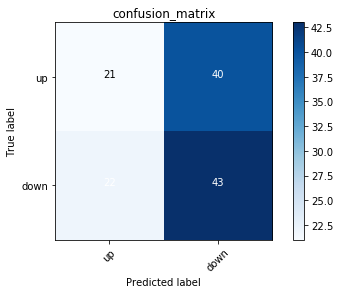

featured/0053_01.csv


In [25]:
from sklearn.metrics import confusion_matrix
cnf=confusion_matrix(test_Y,logistic_regr.predict(test_X))
print('混淆矩陣:\n ',cnf)

import itertools
target_name=['up','down'] #是否生存 
plot_confusion_matrix(cnf,classes=target_name,title='confusion_matrix')
plt.show()
print(filename)

 

In [26]:
survived_predictions = logistic_regr.predict(test_X)
survived_predictions

array([0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1,
       0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1], dtype=int64)

In [8]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [21]:
# 印出係數
print(logistic_regr.coef_)

# 印出截距
print(logistic_regr.intercept_ )

# 印出 p-value
print(f_regression(train_X, train_Y))

[[ -5.65039627e-01   2.25689845e-01   7.79369368e-01  -7.72960127e-01
   -2.74045018e-03  -1.13385608e-02   4.13540931e-02  -4.90685778e-01
   -3.33325510e-01  -3.61625485e-02  -1.49277229e-01  -9.46476839e-02
   -2.29882478e-01   3.41720214e-01  -2.29889638e-01  -1.75977120e-01
   -1.53116544e-01   1.80036387e-02   1.30392538e-01   1.40964733e-01
    1.07007354e-01   4.54690829e-02   3.71463926e-01  -4.17735074e-01
    2.50310741e-01   2.00562289e-01  -4.03797370e-03   7.80903845e-03
    7.03098313e-04   1.36964123e-02  -1.50736938e-02   7.32612585e-03
   -3.43815639e-03   1.35334701e-02  -2.21590982e-02   1.24657433e-02
    4.22305996e-01  -2.11014595e-01]]
[-0.04676983]
(array([ 6.1527018 ,  6.31914515,  6.11942239,  2.77490678,  1.31255714,
        0.76511454,  1.32831953,  6.61533446,  8.27710023,  0.10627416,
        0.08708922,  6.5149674 ,  7.6467072 ,  8.14421264,  6.3950553 ,
        6.35019416,  6.3343123 ,  6.27684582,  6.32876747,  6.4774571 ,
        6.61794639,  6.829366

In [16]:
logistic_regr.

AttributeError: 'LogisticRegression' object has no attribute 'summary'

In [3]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
def plot_logistic(w0,w1,w2):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    X1, X2 = np.mgrid[-2:2:0.25, -2:2:0.25]
    X0 = np.ones(X1.shape)
    Z=np.divide(1,1+np.exp(-1*(np.multiply(w0,X0)+np.multiply(w1,X1)+np.multiply(w2,X2)) ))
    surf = ax.plot_wireframe(X1, X2, Z, cstride=1, rstride=1)
    ax.set_title(("w0=%s, w1=%s, w2=%s")%(w0,w1,w2))
    plt.show()

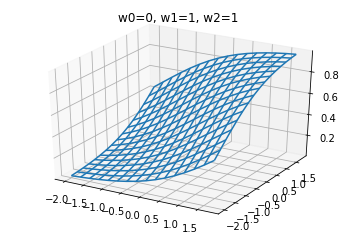

In [4]:
plot_logistic(0,1,1)